<a href="https://colab.research.google.com/github/Molten-Ice/3dGolfPoseDetection/blob/colab/dev-nbs/23-3d_rotation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget -P videos/ https://github.com/Molten-Ice/Deep-Learning/raw/main/Data/golf_video_1.mp4
import os
os.rename('videos/golf_video_1.mp4', 'videos/output.mp4')

!wget https://github.com/Molten-Ice/Deep-Learning/raw/main/Data/keypoints_2d.npz
!wget https://github.com/Molten-Ice/Deep-Learning/raw/main/Data/keypoints_3d.npy
!wget https://github.com/Molten-Ice/Deep-Learning/raw/main/Data/club_keypoints_2d.npy

--2023-05-04 21:18:07--  https://github.com/Molten-Ice/Deep-Learning/raw/main/Data/golf_video_1.mp4
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Molten-Ice/Deep-Learning/main/Data/golf_video_1.mp4 [following]
--2023-05-04 21:18:07--  https://raw.githubusercontent.com/Molten-Ice/Deep-Learning/main/Data/golf_video_1.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20556022 (20M) [application/octet-stream]
Saving to: ‘videos/golf_video_1.mp4’

golf_video_1.mp4    100%[===================>]  19.60M  --.-KB/s    in 0.1s    

2023-05-04 21:18:08 (140 MB/s) - ‘videos/golf_video_1.mp4’ saved [2055

In [2]:
!git clone https://github.com/facebookresearch/VideoPose3D.git

Cloning into 'VideoPose3D'...
remote: Enumerating objects: 121, done.
remote: Total 121 (delta 0), reused 0 (delta 0), pack-reused 121
Receiving objects: 100% (121/121), 9.53 MiB | 28.45 MiB/s, done.
Resolving deltas: 100% (41/41), done.


In [3]:
import sys
sys.path.insert(1, '/content/VideoPose3D')

from common.custom_dataset import CustomDataset
dataset = CustomDataset('keypoints_2d.npz')

In [6]:
dataset.skeleton()

In [168]:
import numpy as np

args_viz_subject = "output.mp4"
args_viz_action = "custom"
args_viz_camera = 0


print('Loading 2D detections...')
keypoints = np.load('keypoints_2d.npz', allow_pickle=True)
keypoints_metadata = keypoints['metadata'].item()
keypoints_symmetry = keypoints_metadata['keypoints_symmetry']
kps_left, kps_right = list(keypoints_symmetry[0]), list(keypoints_symmetry[1])
# joints_left, joints_right = list(dataset.skeleton().joints_left()), list(dataset.skeleton().joints_right())
joints_left, joints_right = [4, 5, 6, 11, 12, 13], [1, 2, 3, 14, 15, 16]
skeleton_parents = [-1,  0,  1,  2,  0,  4,  5,  0,  7,  8,  9,  8, 11, 12,  8, 14, 15]
keypoints = keypoints['positions_2d'].item()[args_viz_subject][args_viz_action][args_viz_camera]

print(keypoints.shape, keypoints[:1, :2])

print('Loading 3D detections...')
poses = np.load('keypoints_3d.npy')
print(poses.shape, poses[:1, :2])

print('Loading 2D club...')
club_keypoints_2d = np.load('club_keypoints_2d.npy')
print(club_keypoints_2d.shape, club_keypoints_2d[:1])

Loading 2D detections...
(239, 17, 2) [[[897.2394  293.26077]
  [910.1706  277.42313]]]
Loading 3D detections...
(239, 17, 3) [[[-2.6511225e-06 -3.2621378e-05  2.8868028e-06]
  [-1.2768735e-01 -1.1986511e-02 -1.9267708e-02]]]
Loading 2D club...
(239, 2, 2) [[[ 938  607]
  [ 938 1011]]]


In [8]:
import matplotlib
matplotlib.use('Agg')

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, writers
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import subprocess as sp

def get_resolution(filename):
    """Returns height, width of video"""
    command = ['ffprobe', '-v', 'error', '-select_streams', 'v:0',
               '-show_entries', 'stream=width,height', '-of', 'csv=p=0', filename]
    with sp.Popen(command, stdout=sp.PIPE, bufsize=-1) as pipe:
        for line in pipe.stdout:
            w, h = line.decode().strip().split(',')
            return int(w), int(h)
            
def get_fps(filename):
    """Returns the fps of the video"""
    command = ['ffprobe', '-v', 'error', '-select_streams', 'v:0',
               '-show_entries', 'stream=r_frame_rate', '-of', 'csv=p=0', filename]
    with sp.Popen(command, stdout=sp.PIPE, bufsize=-1) as pipe:
        for line in pipe.stdout:
            a, b = line.decode().strip().split('/')
            return int(a) / int(b)

def read_video(filename, skip=0, limit=-1):
    """This function reads a video file and yields each frame as a numpy array in RGB format"""
    w, h = get_resolution(filename)
    
    command = ['ffmpeg',
            '-i', filename,
            '-f', 'image2pipe',
            '-pix_fmt', 'rgb24',
            '-vsync', '0',
            '-vcodec', 'rawvideo', '-']
    
    i = 0
    with sp.Popen(command, stdout = sp.PIPE, bufsize=-1) as pipe:
        while True:
            data = pipe.stdout.read(w*h*3)
            if not data:
                break
            i += 1
            if i > limit and limit != -1:
                continue
            if i > skip:
                yield np.frombuffer(data, dtype='uint8').reshape((h, w, 3))

In [169]:
#detectron keypoints

# "keypoints": [ "nose", "left_eye", "right_eye", "left_ear", "right_ear", "left_shoulder",
# "right_shoulder", "left_elbow", "right_elbow", "left_wrist", "right_wrist", "left_hip",
# "right_hip", "left_knee", "right_knee", "left_ankle", "right_ankle" ]

i = 0 # frame num
pos = poses[i].copy()
frame_2d_keypoints = keypoints[i].copy()
club_2d_keypoints = club_keypoints_2d[i].copy()

# pos[1:-2]= 0
# frame_2d_keypoints[1:-2] = 0 # note index 0 is already [0,0,0]
# pos[:3], frame_2d_keypoints[:3]
pos, frame_2d_keypoints

(array([[-2.65112249e-06, -3.26213776e-05,  2.88680280e-06],
        [-1.27687350e-01, -1.19865108e-02, -1.92677081e-02],
        [-1.98236495e-01,  3.88588309e-01, -1.62839547e-01],
        [-3.10032666e-01,  8.04255903e-01, -1.12632558e-01],
        [ 1.27685905e-01,  1.19778980e-02,  1.92725547e-02],
        [ 1.89711675e-01,  4.02689278e-01, -1.46571100e-01],
        [ 2.49239564e-01,  8.22589755e-01, -9.62081105e-02],
        [ 2.62882859e-02, -2.02875003e-01, -7.81644583e-02],
        [ 9.76078212e-03, -4.01318431e-01, -2.38329530e-01],
        [-5.08246850e-03, -4.13500488e-01, -3.35521042e-01],
        [-1.96430553e-02, -5.18386960e-01, -3.17487091e-01],
        [ 1.45772994e-01, -3.73337924e-01, -2.06198752e-01],
        [ 1.45423949e-01, -1.11042626e-01, -1.85246065e-01],
        [ 8.38845968e-02,  1.10619143e-01, -2.02705532e-01],
        [-1.16545424e-01, -3.29699039e-01, -2.49879792e-01],
        [-8.26726407e-02, -4.90614325e-02, -2.74060637e-01],
        [-3.81413754e-03

In [176]:
import math

def dot_product(a, b):
    return a[0] * b[0] + a[1] * b[1]

def magnitude(vector):
    return math.sqrt(vector[0]**2 + vector[1]**2)

def angle_between_vectors(a, b):
    if len(a) != 2 or len(b) != 2:
        raise ValueError("Both vectors must have exactly 2 dimensions")

    dot_product_ab = dot_product(a, b)
    magnitude_a = magnitude(a)
    magnitude_b = magnitude(b)

    cos_angle = dot_product_ab / (magnitude_a * magnitude_b)
    angle_rad = math.acos(cos_angle)
    angle_deg = math.degrees(angle_rad)

    return angle_deg

def euclidean_distance_2d(point1, point2):
    if len(point1) != 2 or len(point2) != 2:
        raise ValueError("Points must have 2 dimensions")

    distance = ((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2) ** 0.5
    return distance

def rotate_points(points, pivot, angle_degrees):
    angle_radians = math.radians(angle_degrees)
    rotated_points = []

    for point in points:
        # Translate the point so that the pivot point becomes the origin
        translated_x = point[0] - pivot[0]
        translated_y = point[1] - pivot[1]

        # Rotate the translated point around the origin
        rotated_x = translated_x * math.cos(angle_radians) - translated_y * math.sin(angle_radians)
        rotated_y = translated_x * math.sin(angle_radians) + translated_y * math.cos(angle_radians)

        # Translate the rotated point back to the original coordinate system
        final_x = rotated_x + pivot[0]
        final_y = rotated_y + pivot[1]

        rotated_points.append((final_x, final_y))

    return np.array(rotated_points)

In [205]:
#-- red is right --
# [16 red wrist, 15 red elbow, 14 red shoulder, 13 black wrist, 12 black elbow, 11 black shoulder, 10 tip of head, 9 second point from head, 
# 8 middle of shoulder, 7 stomach, 6 black foot, 5 black knee, 4 black hip, 3 red foot, 2 red knee, 1 red hip, 0 middle of thighs

# "keypoints": [ 0"nose", 1"left_eye", 2"right_eye", 3"left_ear", 4"right_ear", 5"left_shoulder",
# 6"right_shoulder", 7"left_elbow", 8"right_elbow", 9"left_wrist", 10"right_wrist", 11"left_hip",
# 12"right_hip", 13"left_knee", 14"right_knee", 15"left_ankle", 16"right_ankle" ]
valid_pairings = np.array([[16, 10], [15, 8], [14, 6], [13, 9], [12, 7], [11, 5], [6, 15], [5, 13], [4, 11], [3, 16], [2, 14], [1, 12]])  # [10/9, 0]

In [209]:
pos = poses[i].copy()
#Lets say the 3 coordinates are x, y, z, and we directly flatten along the z dimension (as we have no intrinsic camera parameters)
#indexing from 0
#3d pose: 3 = red foot, 6 = black foot, 16 = red wrist
#2d pose: 10 = red wrist, 15 = black foot, 16 = red foot

red_foot_3d, black_foot_3d, red_wrist_3d = pos[[3, 6, 16]]
red_foot_2d, black_foot_2d, red_wrist_2d = frame_2d_keypoints[[16, 15, 10]]
print(red_foot_2d, black_foot_2d, red_wrist_2d)
print("3D original", red_foot_3d, black_foot_3d, red_wrist_3d)

#Only rotates in the 2d xy plane
rotation_angle_red_foot = angle_between_vectors(red_wrist_3d[:2], red_foot_3d[:2]) - angle_between_vectors(red_wrist_2d, red_foot_2d)
pos[:, :2] = rotate_points(pos[:, :2], pivot=red_wrist_3d[:2], angle_degrees=rotation_angle_red_foot)
red_foot_3d, black_foot_3d, red_wrist_3d = pos[[3, 6, 16]]
print(f"3D after red_foot rotation of {rotation_angle_red_foot:3f} degress", red_foot_3d, black_foot_3d, red_wrist_3d)

#Scale euclidean distance between red foot and wrist so they align in the 2d xy plane
distance_from_3d = euclidean_distance_2d(red_wrist_3d[:2], red_foot_3d[:2])
distance_from_2d = euclidean_distance_2d(red_wrist_2d, red_foot_2d)
scale_factor = distance_from_2d/distance_from_3d
pos = pos*scale_factor
red_foot_3d, black_foot_3d, red_wrist_3d = pos[[3, 6, 16]]
print(f"3D after scale factor: {scale_factor:.4f} |", red_foot_3d, black_foot_3d, red_wrist_3d)

#Translate 3d -> 2d wrist so images are aligned
translation_vector = red_wrist_3d[:2] - red_wrist_2d
pos[:, :2] -= translation_vector
red_foot_3d, black_foot_3d, red_wrist_3d = pos[[3, 6, 16]]

differences = pos[valid_pairings[:, 0], :2] -  frame_2d_keypoints[valid_pairings[:, 1]]
print(f"Average difference: {abs(differences).mean():.3f}")

print(f"3D after translation vector: {translation_vector} |", red_foot_3d, black_foot_3d, red_wrist_3d)
print()
print("Projected:", red_foot_3d[:2], black_foot_3d[:2], red_wrist_3d[:2])
print("Real:", red_foot_2d, black_foot_2d, red_wrist_2d )

[759.3061 932.5254] [1035.1726  935.405 ] [908.73376 594.1759 ]
3D original [-0.31003267  0.8042559  -0.11263256] [ 0.24923956  0.82258976 -0.09620811] [-0.00381414  0.14965466 -0.32433984]
Average difference: 757.733
3D after red_foot rotation of 1.954010 degress [-0.33217475  0.793434   -0.11263256] [ 0.22614713  0.83082694 -0.09620811] [-0.00381414  0.14965466 -0.32433984]
Average difference: 757.732
3D after scale factor: 511.8099 | [-170.01033  406.0874   -57.64646] [115.74435 425.2255  -49.24027] [  -1.9521135   76.59474   -166.00035  ]
Average difference: 716.819
Average difference: 12.563
3D after translation vector: [-910.68585 -517.5812 ] | [740.67554 923.6686  -57.64646] [1026.4302   942.80664  -49.24027] [ 908.73376  594.1759  -166.00035]

Projected: [740.67554 923.6686 ] [1026.4302   942.80664] [908.73376 594.1759 ]
Real: [759.3061 932.5254] [1035.1726  935.405 ] [908.73376 594.1759 ]


In [212]:
differences = pos[valid_pairings[:, 0], :2] -  frame_2d_keypoints[valid_pairings[:, 1]]
print(f"Average difference: {abs(differences).mean():.3f}")
differences

Average difference: 12.563


array([[  0.        ,   0.        ],
       [  7.671692  ,  -2.2369385 ],
       [ 29.726196  , -15.357208  ],
       [  9.620056  ,  11.798889  ],
       [ 17.667236  ,   0.27505493],
       [  5.1815186 ,  -2.8657532 ],
       [ -8.742432  ,   7.4016113 ],
       [  9.803528  , -12.610657  ],
       [ 19.378418  , -36.453186  ],
       [-18.630554  ,  -8.856812  ],
       [ -5.916382  , -26.593689  ],
       [ -4.5064697 , -40.20984   ]], dtype=float32)

<Figure size 640x480 with 0 Axes>

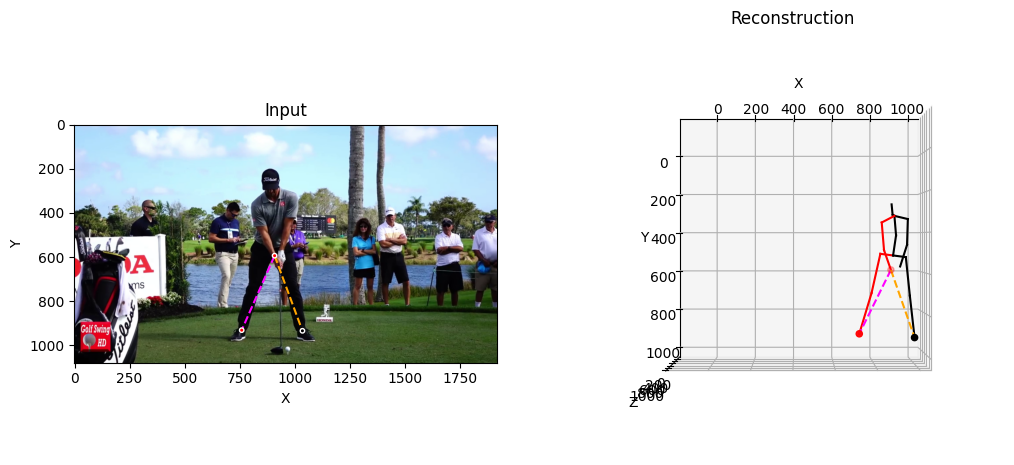

In [191]:
# from google.colab import output
# output.enable_custom_widget_manager()
# %matplotlib widget

#use %matplotlib inline for non interactive
%matplotlib inline

size = 6

plt.clf() 
fig = plt.figure(figsize=(2*size, size)) # 6x6
ax_in = fig.add_subplot(1, 2, 1)
# ax_in.get_xaxis().set_visible(False)
# ax_in.get_yaxis().set_visible(False)

ax_in.set_xlabel('X')
ax_in.set_ylabel('Y')

# ax_in.set_axis_off()
ax_in.set_title('Input')
ax_3d = []
ax = fig.add_subplot(1, 2, 2, projection='3d')

max_value = max(pos.max(), red_foot_3d.max(), black_foot_3d.max(), red_wrist_3d.max())
min_value = min(pos.min(), red_foot_3d.min(), black_foot_3d.min(), red_wrist_3d.min())
ax.set_xlim3d([min_value, max_value])
ax.set_zlim3d([min_value, max_value])
ax.set_ylim3d([min_value, max_value])
try:
    ax.set_aspect('equal')
except NotImplementedError:
    ax.set_aspect('auto')
# ax.set_xticklabels([])
# ax.set_yticklabels([])
# ax.set_zticklabels([])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# ax.dist = 7.5
ax.set_title("Reconstruction") #, pad=35

# Load video using ffmpeg
for f in read_video('videos/output.mp4'):
    frame = f
    break


# Update 2D poses
joints_right_2d = keypoints_symmetry[1]
colors_2d = np.full(keypoints.shape[1], 'black')
colors_2d[joints_right_2d] = 'red'
image = ax_in.imshow(frame, aspect='equal')


for j, j_parent in enumerate(skeleton_parents):
    if j_parent == -1:
        continue
        
    col = 'red' if j in joints_right else 'black'
    
    ax.plot([pos[j, 0], pos[j_parent, 0]],
                  [pos[j, 1], pos[j_parent, 1]],
                  [pos[j, 2], pos[j_parent, 2]], zdir='z', c=col)
    
skeleton_layout = np.array([[16,14],[14,12],[17,15],[15,13],[12,13],[6,12],[7,13],[6,7], \
                  [6,8],[7,9],[8,10],[9,11],[2,3],[1,2],[1,3],[2,4],[3,5],[4,6],[5,7]])


#-- red is right --
# [16 red wrist, 15 red elbow, 14 red shoulder, 13 black wrist, 12 black elbow, 11 black shoulder, 10 tip of head, 9 second point from head, 
# 8 middle of shoulder, 7 stomach, 6 black foot, 5 black knee, 4 black hip, 3 red foot, 2 red knee, 1 red hip, 0 middle of thighs

# "keypoints": [ "nose", "left_eye", "right_eye", "left_ear", "right_ear", "left_shoulder",
# "right_shoulder", "left_elbow", "right_elbow", "left_wrist", "right_wrist", "left_hip",
# "right_hip", "left_knee", "right_knee", "left_ankle", "right_ankle" ]

ax.scatter(*np.array([red_foot_3d, black_foot_3d, red_wrist_3d]).T, color = ['red', 'black', 'red'])
ax.plot(*np.array([red_wrist_3d, red_foot_3d]).T, linestyle = 'dashed', color = 'fuchsia')
ax.plot(*np.array([red_wrist_3d, black_foot_3d]).T, linestyle = 'dashed', color = 'orange')

points = ax_in.scatter(*np.array([red_foot_2d, black_foot_2d, red_wrist_2d]).T, 10, color=colors_2d[[16, 15, 10]], edgecolors='white', zorder=10)
ax_in.plot(*np.array([red_wrist_2d, red_foot_2d]).T, linestyle = 'dashed', color = 'fuchsia')
ax_in.plot(*np.array([red_wrist_2d, black_foot_2d]).T, linestyle = 'dashed', color = 'orange')


# ax.scatter(*pos[[3, 6, 16]].T, color = ['red', 'black', 'red'])
# points = ax_in.scatter(*frame_2d_keypoints[[0, 15, 16]].T, 10, color=['blue', 'black', 'red'], edgecolors='white', zorder=10)
# for pair in np.array([[1, 16], [1, 17]]):
#     ax_in.plot(*frame_2d_keypoints[pair-1].T, linestyle = 'dashed')

# points = ax_in.scatter(*frame_2d_keypoints[[10, 15, 16]].T, 10, color=colors_2d[[10, 15, 16]], edgecolors='white', zorder=10)
# points = ax_in.scatter(*frame_2d_keypoints.T, 10, color=colors_2d, edgecolors='white', zorder=10)
# for pair in skeleton_layout:
#     ax_in.plot(*frame_2d_keypoints[pair-1].T, linestyle = 'dashed')

# club_points = ax_in.scatter(*club_2d_keypoints.T, 10, color=['blue', 'blue'], edgecolors='white', zorder=10)
# ax_in.plot(*club_2d_keypoints.T, linestyle = 'dashed')

ax.view_init(elev=90., azim=90) # Note Y axis increases as it goes down on image so need to rotate 3d plot
ax.invert_xaxis()
plt.show()

<Figure size 640x480 with 0 Axes>

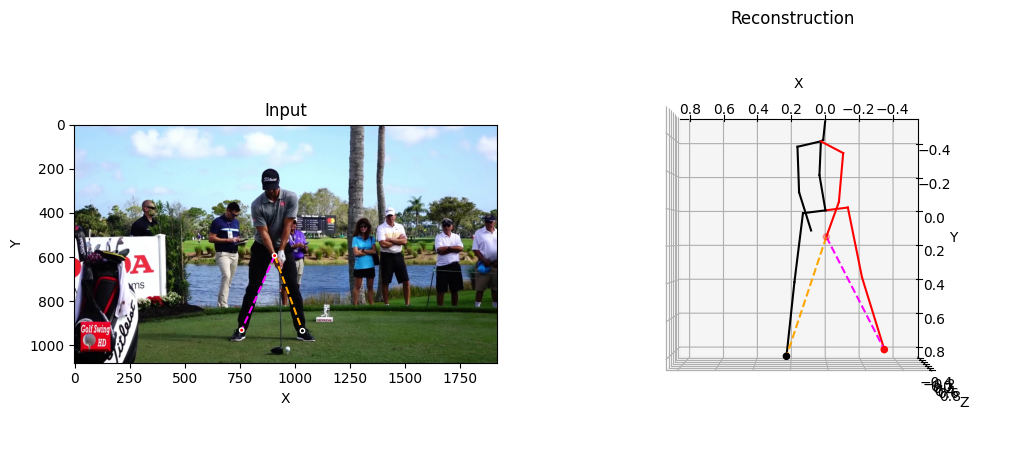

<Figure size 640x480 with 0 Axes>

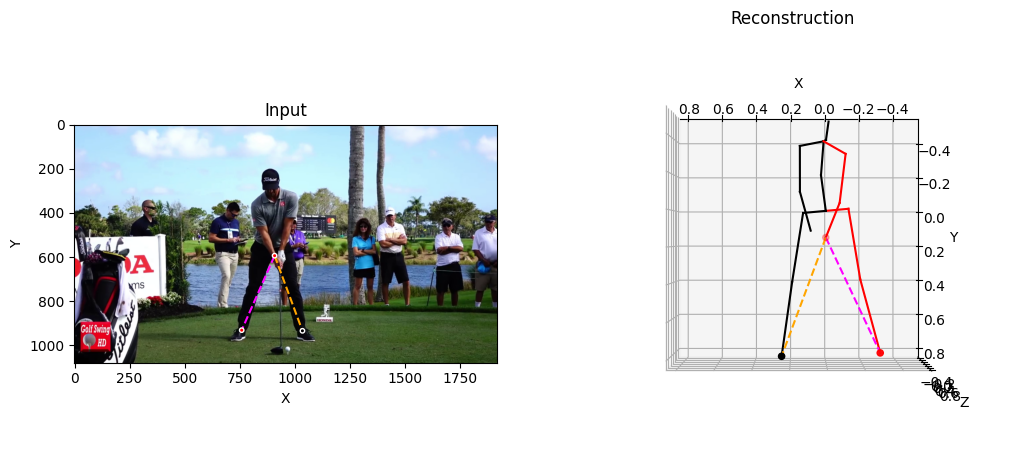